In [2]:
import networkx as nx
import numpy as np
import random
import itertools
import collections

seed = 1005
np.random.seed(seed)
random.seed(seed)

In [3]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

reds = cm.get_cmap('Reds')
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Exercise five

### The classroom

We first generate a random classroom of $n$ individuals based on the Barabási–Albert model.

In [5]:
class SocialNetwork:
    def __init__(self, G):
        
        self.G =  G
        self.layout = nx.spring_layout(self.G)
        
    @property
    def eigen(self):
        return list(nx.eigenvector_centrality(self.G).values())
    
    @property
    def utility(self):
        return sum(degree for node, degree in self.G.degree)
    
    @property
    def partition(self):
        return kernighan_lin_bisection(self.G)
    
        
    def draw(self, ax, eigen_color=True, **kwargs):
        
        color_args = {
            "vmin": min(c.eigen) / 3,
            "vmax": max(c.eigen),
            "node_color": self.eigen,
            "cmap": reds
        } if eigen_color else { "cmap": "red" }

            
        nx.draw(
            self.G, self.layout,
            ax = ax,
            **color_args,
            **kwargs)
        
        return ax
    
    def draw_subgraphs(self, A, B, ax):
        
        AG = self.G.subgraph(A)
        BG = self.G.subgraph(B)
        
        nx.draw(AG, self.layout, node_color="r", ax = ax)
        nx.draw(BG, self.layout, node_color="b", ax = ax)
        
        return ax
    
    def draw_degree(self, ax):
        
        degrees = sorted([d for n, d in self.G.degree()], reverse=True)
        degree_count = collections.Counter(degrees)
        
        deg, cnt = zip(*degree_count.items())
        
        ax.bar(deg, cnt)
        ax.set_xlabel("Degrees")
        ax.set_ylabel("Count")
        
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)
        
        return ax

In [6]:
c = SocialNetwork(
    nx.extended_barabasi_albert_graph(30, 2, 0.2, 0.5)
)

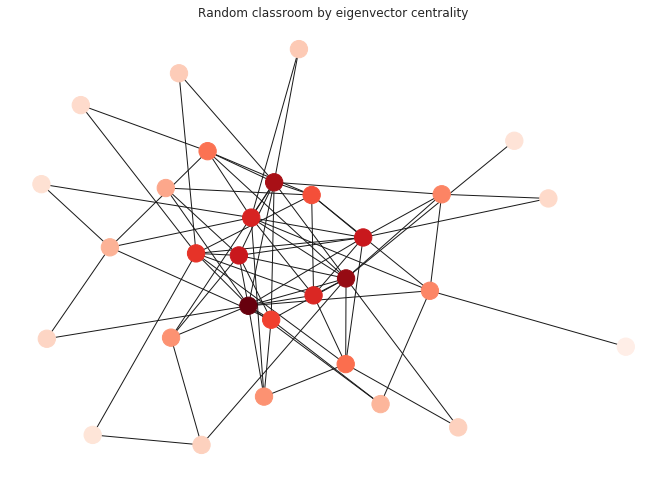

In [7]:
fig, ax = plt.subplots()
c.draw(ax)
ax.set_title("Random classroom by eigenvector centrality")
fig.show()

### Partition

We want to find the partition that minimizes the number of edges between classes. 

In [8]:
A, B = c.partition

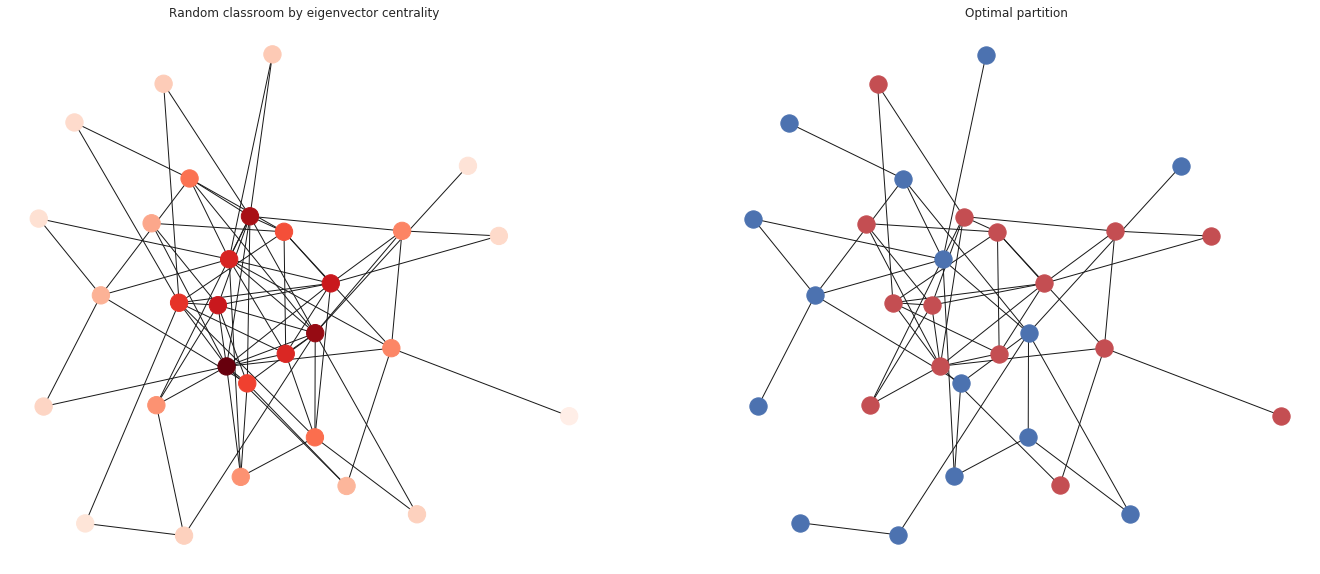

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (11.7 * 2, 10))


c.draw(ax1)
c.draw_subgraphs(A, B, ax2)

ax1.set_title("Random classroom by eigenvector centrality")
ax2.set_title("Optimal partition")
fig.savefig("plots/classroom.png")
fig.show()

### A smaller class

In [10]:
c = SocialNetwork(
    nx.extended_barabasi_albert_graph(4, 1, 0.2, 0.5)
)

A, B = c.partition

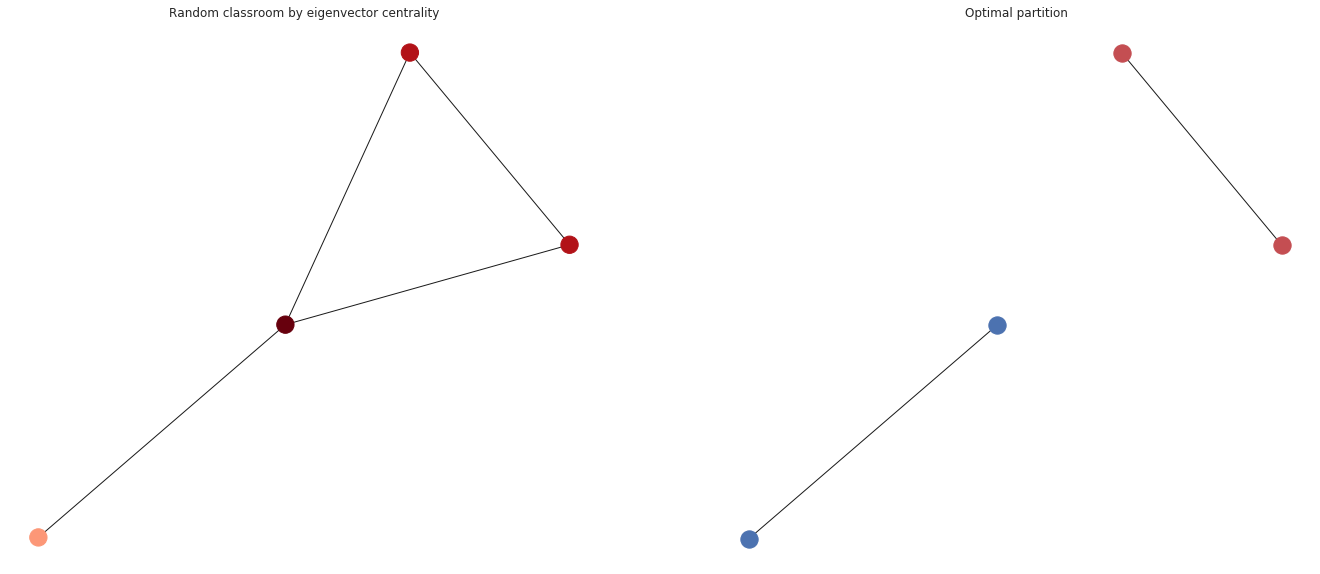

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (11.7 * 2, 10))


c.draw(ax1)
c.draw_subgraphs(A, B, ax2)

ax1.set_title("Random classroom by eigenvector centrality")
ax2.set_title("Optimal partition")

fig.show()

## Exercise six

In [86]:
A_G = nx.to_numpy_matrix(nx.random_geometric_graph(100, 0.2))
W_G = np.random.rand(*A_G.shape)
W_G[np.where(A_G == 0.)] = 0.

office = SocialNetwork(nx.from_numpy_matrix(W_G))

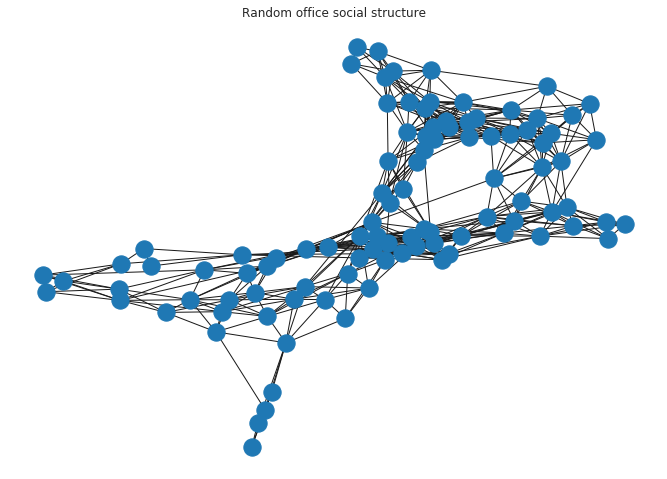

In [87]:
fig, ax = plt.subplots()
office.draw(ax, eigen_color=False)
ax.set_title("Random office social structure")
fig.show()

In [94]:
def friend_explore(G, initial = None, random_jump = False):

    initial = initial if initial is not None else random.randint(0, len(G) - 1)
    
    found_nodes = set([initial])
    current = initial

    while True:
        
        neighbors = sorted(
            ((node, edge["weight"]) for node, edge in G[current].items() if node not in found_nodes), 
            key = lambda tup: tup[1], reverse = True
        )
        
        N = len(neighbors)

        if N == 0: break # No more neighbors to traverse
    
        jump_idx = random.randint(0, N - 1) if random_jump else 0
        jump_to = neighbors[jump_idx][0]

        current = jump_to
        found_nodes.add(jump_to)
        
        
    not_found = set((n for n in G.nodes if n not in found_nodes))    
        
    return found_nodes, not_found

In [113]:
found = set()

for initial in random.sample(office.G.nodes, 3):
    found_i, _ = friend_explore(office.G, initial = initial)
    found = found | found_i
    
not_found = set((node for node in office.G.nodes if node not in found))

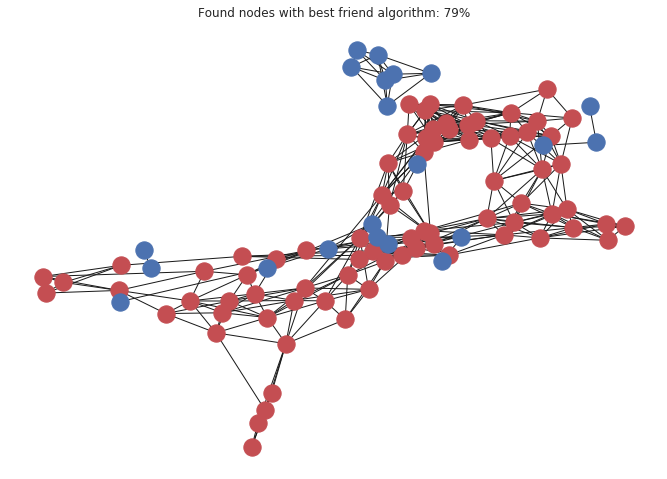

In [116]:
fig, ax = plt.subplots()

office.draw_subgraphs(found, not_found, ax)
ax.set_title(f"Found nodes with best friend algorithm: {100*len(found) / len(office.G.nodes):.0f}%")

fig.show()
